In [121]:
from scipy.stats import kde
import utils.stan_utility as stan_utility
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl

In [116]:
# util dict for storing colors

colors = {
    "light": "#FFFCDC",
    "light_highlight":"#FEF590",
    "mid": "#FDED2A",
    "mid_highlight": "#f0dc05",
    "dark": "#EECA02",
    "dark_highlight":"#BB9700",
    "green":"#00FF00",
    "light_grey":"#DDDDDD"
    
}

In [117]:
# plot settings

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [163]:
# util functions

def compile_model(model_path):
    return stan_utility.compile_model(model_path)

def fit_model(model_path, data, i, warmup, chains, seed, algorithm="Fixed_param"):
    model = compile_model(model_path)
    return  model, sampling_on_model(model=model,
                  data=data,
                  algorithm=algorithm,
                  i=i,
                  warmup=warmup,
                  chains = chains,
                  seed = seed)

def decorate_plot(p, title, x_label, y_label, grid=True):
    p.set_title(title)
    p.set_xlabel(x_label)
    p.set_ylabel(y_label)
    p.grid(True)
    
def read_model(model_path):
    with open('model_path') as f:
        print(f.read())
        
def sampling_on_model(model, data, algorithm, i, seed, warmup, chains):
    return model.sampling(data=data,
                  algorithm=algorithm,
                  iter=i,
                  warmup=warmup,
                  chains = chains,
                  seed = seed)

Using cached StanModel


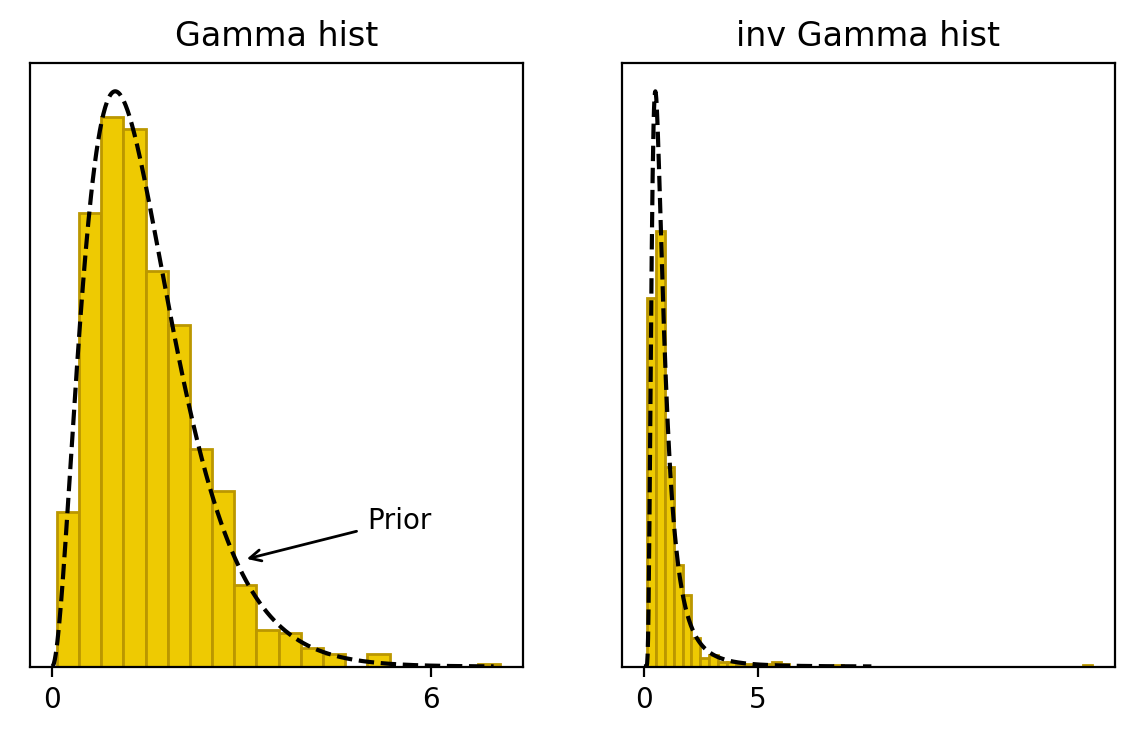

In [119]:
# Gamma family distributions 
data = {'alpha': 3, 'beta': 2}
gamma_model, gamma_fit = fit_model(model_path ='stan_model/gamma.stan',
                       data = data,
                       i=1000, 
                       warmup=0,
                       chains=1,
                       seed = 25052020)

gamma_params = gamma_fit.extract() # gamma, inv_gamma

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
f_plot=axes[0] # for gamma
f_plot.hist(gamma_params['gamma'],
         bins=20,
         color=colors['dark'],
         edgecolor=colors['dark_highlight'],
         density=True)
                          
                         
f_plot.plot(np.linspace(0,7,500),
         stats.gamma.pdf(np.linspace(0,7,500),a=data['alpha'],scale=1/data['beta']),
         color='black',
         linestyle='--')
                          
f_plot.set_xticks([0,6])
f_plot.set_yticks([])
f_plot.set_title(r'Gamma hist')
f_plot.annotate('Prior',xy=(3,0.1),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})

s_plot=axes[1] # for inv_gamma
s_plot.hist(gamma_params['inv_gamma'],
            bins=50,
            color=colors['dark'],
            edgecolor=colors['dark_highlight'],
            density=True)

s_plot.plot(np.linspace(0,10,500),
            stats.invgamma.pdf(np.linspace(0,10,500), a=data['alpha'], scale=data['beta']),
                               color='black',
                               linestyle='--')
s_plot.set_yticks([])
s_plot.set_xticks([0,5])
s_plot.set_title('inv Gamma hist')

plt.show()


Using cached StanModel


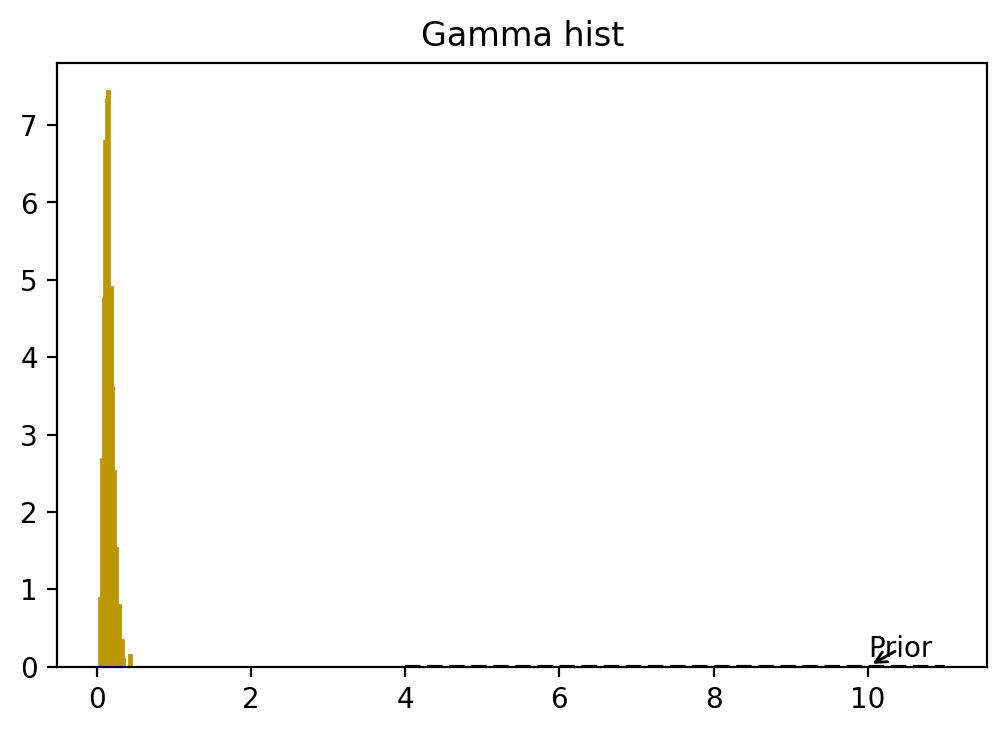

In [157]:
# tuning gamma

data= {
    'lowerBound':5,
    'upperBound':10,
    'alphaGuess':8,
    'betaGuess':1,
    'probGuess':0.09
}

gamma_tunned_model, gamma_tunned_fit =  fit_model(model_path ='stan_model/gamma_tune.stan',
                       data = data,
                       i=1000, 
                       warmup=0,
                       chains=1,
                       seed = 1052020)

tunning_params = {
    'beta': np.round(gamma_tunned_fit.extract()['alpha'][0]),
    'alpha': np.round(gamma_tunned_fit.extract()['beta'][0])
}

sim = gamma_model.sampling(tunning_params,
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)



sim = gamma_model.sampling(data=tunning_params,
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

tunned_params=sim.extract()

plt.hist(tunned_params['gamma'],
         bins=20,
         color=colors['dark'],
         edgecolor=colors['dark_highlight'],
         density=True)


plt.plot(np.linspace(4,11,500),
         stats.gamma.pdf(np.linspace(4,11,500),a=tunning_params['alpha'],scale=1/tunning_params['beta']),
         color='black',
         linestyle='--')

plt.title(r'Gamma hist')
plt.annotate('Prior',xy=(10, 0),xytext=(10,0.13),arrowprops={'arrowstyle':'->'})

plt.show()

Using cached StanModel


/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


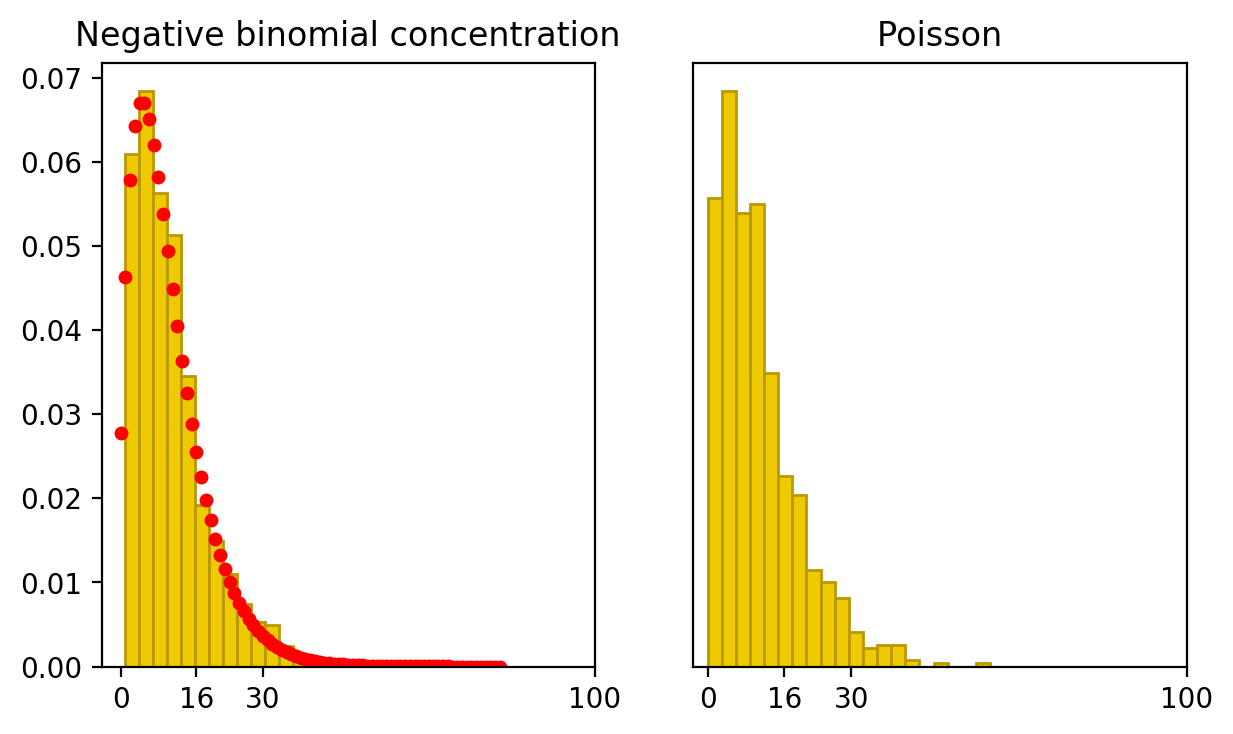

In [158]:
# Negative binomial distribution

data = dict(mean_=10, alpha=2, phi=2, M=1000)

negative_model, negative_fit = fit_model(model_path="stan_model/negative.stan",
                                        data=data,
                                        seed=1052020,
                                        algorithm="Fixed_param", 
                                        i = 1000,
                                        warmup=0,
                                        chains=1)
params=negative_fit.extract()
beta = data['alpha']/data['mean_']
x_con=np.linspace(0, 80, 81)
x_dis=np.linspace(0, 45, 46)
nbinom_fun_con = stats.nbinom(data['alpha'], beta/(beta+1))
nbinom_fun_dis = stats.nbinom(data['phi'], data['phi']/(data['mean_']+data['phi']))

nbinom_pmf_con = []
nbinom_pmf_dis = []

for i in range(0, len(x_con)):
    nbinom_pmf_con.append( nbinom_fun_con.pmf( x_con[i] ))
for i in range(0, len(x_dis)):
    nbinom_pmf_dis.append( nbinom_fun_dis.pmf( x_dis[i] ))
    
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(params['neg_con'],
         bins=20,
         color=colors['dark'],
         edgecolor=colors['dark_highlight'],
         density=True)
ax1.plot(x_con, nbinom_pmf_con,  'ro', markersize=4)
ax1.set_xticks([0,16,30,100])
#ax1.set_yticks([])
ax1.set_title(r'Negative binomial concentration')

ax2=axes[1]
ax2.hist(params['poisson_con'],color=colors["dark"],
         edgecolor=colors["dark_highlight"],
         density=True,bins=20)
ax2.set_yticks([])
ax2.set_xticks([0,16,30,100])
ax2.set_title('Poisson')

plt.show()

In [148]:
# Student-t family distributions

Using cached StanModel


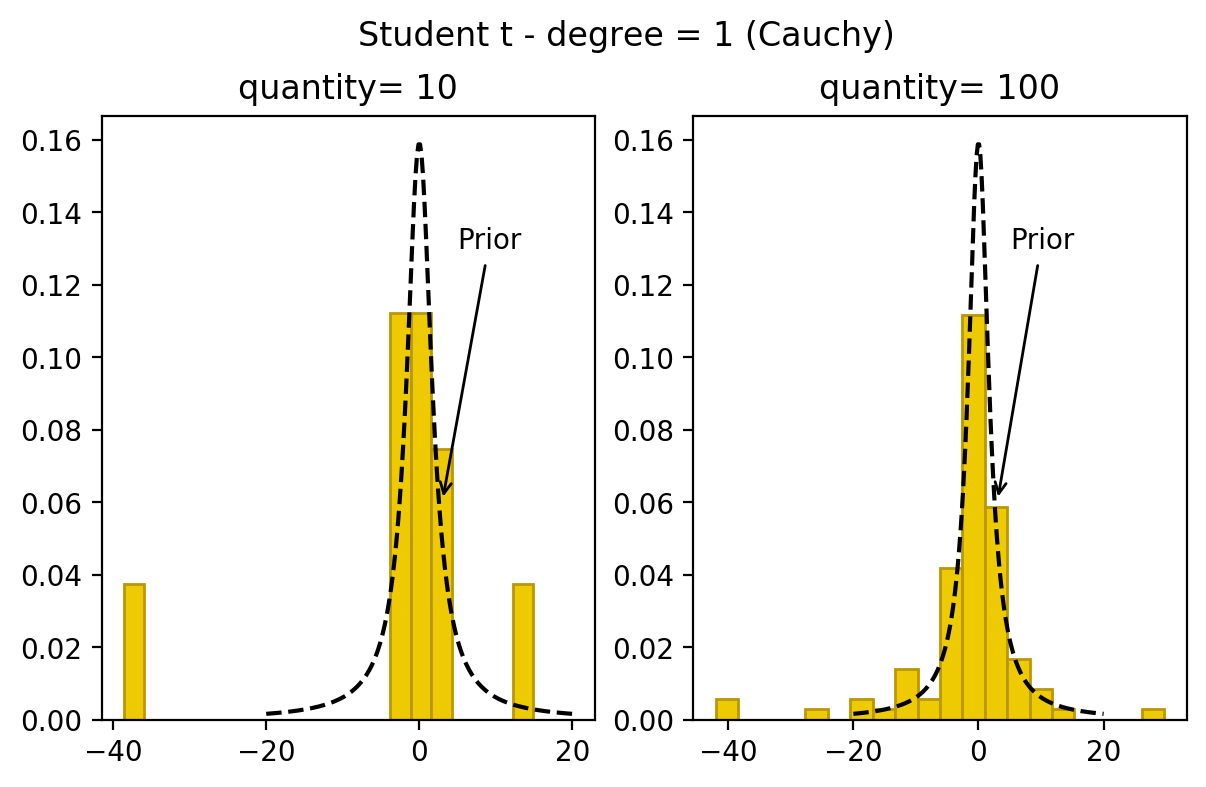

In [171]:
data = {
    "nu": 1, 
    "mu": 0,
    "sigma": 2
}

student_model, student_fitR10 = fit_model(model_path="stan_model/student_t.stan",
                                        data=data,
                                        seed=29042020,
                                        algorithm="Fixed_param", 
                                        i = 10,
                                        warmup=0,
                                        chains=1)

student_fitR100 = sampling_on_model(model=student_model,
                                        data=data,
                                        seed=29042020,
                                        algorithm="Fixed_param", 
                                        i = 100,
                                        warmup=0,
                                        chains=1)
                                  
paramsR10 = student_fitR10.extract()
paramsR1000 = student_fitR100.extract()

x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

fig.suptitle('Student t - degree = 1 (Cauchy)',x= 0.5,y=1, fontsize=12)

r10_plot=axes[0]
r10_plot.hist(paramsR10['y_sim'],
         bins=20,
         color=colors["dark"],
         edgecolor=colors["dark_highlight"],
         density=True)

r10_plot.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')

r10_plot.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
r10_plot.set_title(r'quantity= 10')

r100_plot=axes[1]
r100_plot.hist(paramsR1000['y_sim'],
         bins=20,
         color=colors["dark"],
         edgecolor=colors["dark_highlight"],
         density=True)

r100_plot.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
r100_plot.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
r100_plot.set_title(r'quantity= 100')

plt.show()

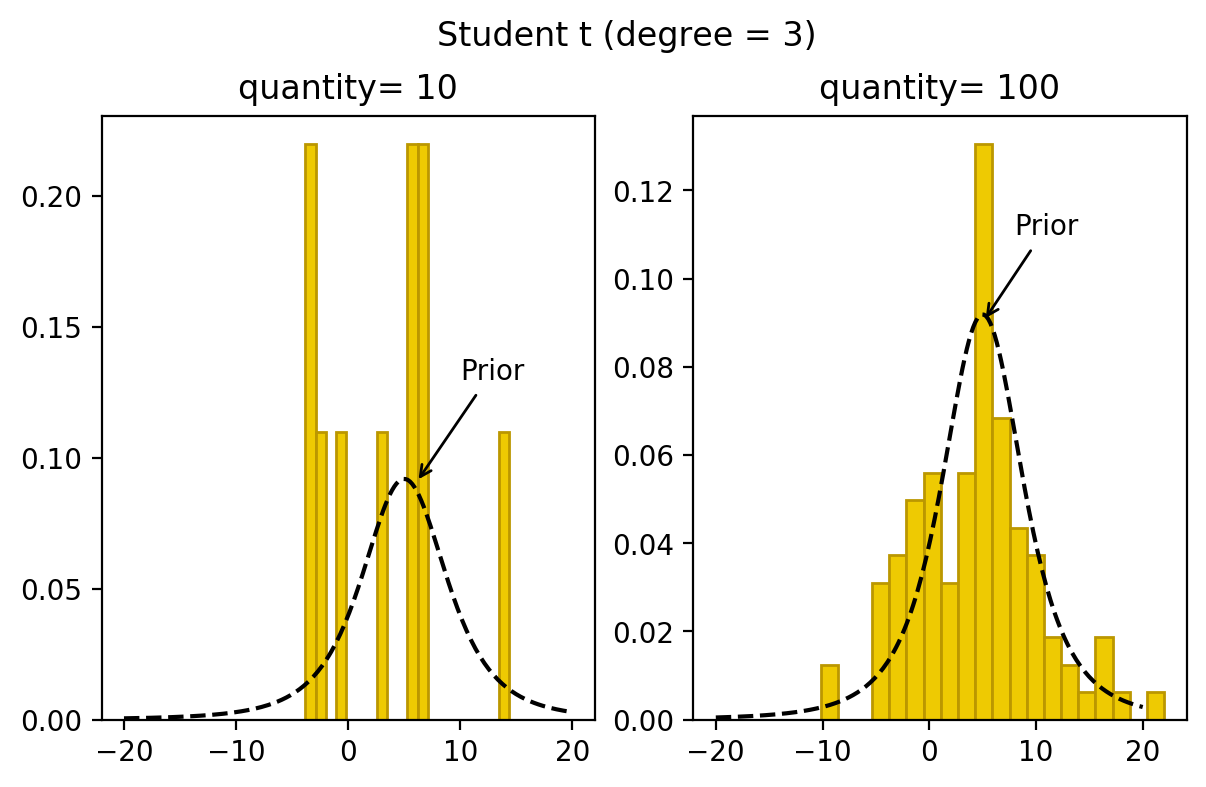

In [176]:
data = {
    'nu':3,
    'mu':5,
    'sigma':4
}

student_fitR10_1 = sampling_on_model(model=student_model,
                                        data=data,
                                        seed=29042020,
                                        algorithm="Fixed_param", 
                                        i = 10,
                                        warmup=0,
                                        chains=1)
student_fitR100_1 = sampling_on_model(model=student_model,
                                        data=data,
                                        seed=29042020,
                                        algorithm="Fixed_param", 
                                        i = 100,
                                        warmup=0,
                                        chains=1)

paramsR10_1 = student_fitR10_1.extract()
paramsR100_1 = student_fitR100_1.extract()

x=np.linspace(-20,20,200)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
fig.suptitle('Student t (degree = 3)',x= 0.5,y=1, fontsize=12)

r10_plot_1=axes[0]
r10_plot_1.hist(paramsR10_1["y_sim"],
                bins=20,
                color=colors["dark"],
                edgecolor=colors["dark_highlight"],
                density=True)

r10_plot_1.plot(x,stats.t.pdf(x, df=3, loc=5, scale=4),color='black',linestyle='--')
r10_plot_1.annotate('Prior',xy=(6,0.09),xytext=(10,0.13),arrowprops={'arrowstyle':'->'})
r10_plot_1.set_title(r'quantity= 10')

r100_plot_1=axes[1]
r100_plot_1.hist(paramsR100_1["y_sim"],
                 bins=20,
                 color=colors["dark"],
                 edgecolor=colors["dark_highlight"],
                 density=True)

r100_plot_1.plot(x,stats.t.pdf(x, df=3, loc=5, scale=4),color='black',linestyle='--')
r100_plot_1.annotate('Prior',xy=(5,0.09),xytext=(8,0.11),arrowprops={'arrowstyle':'->'})
r100_plot_1.set_title(r'quantity= 100')

plt.show()

Using cached StanModel


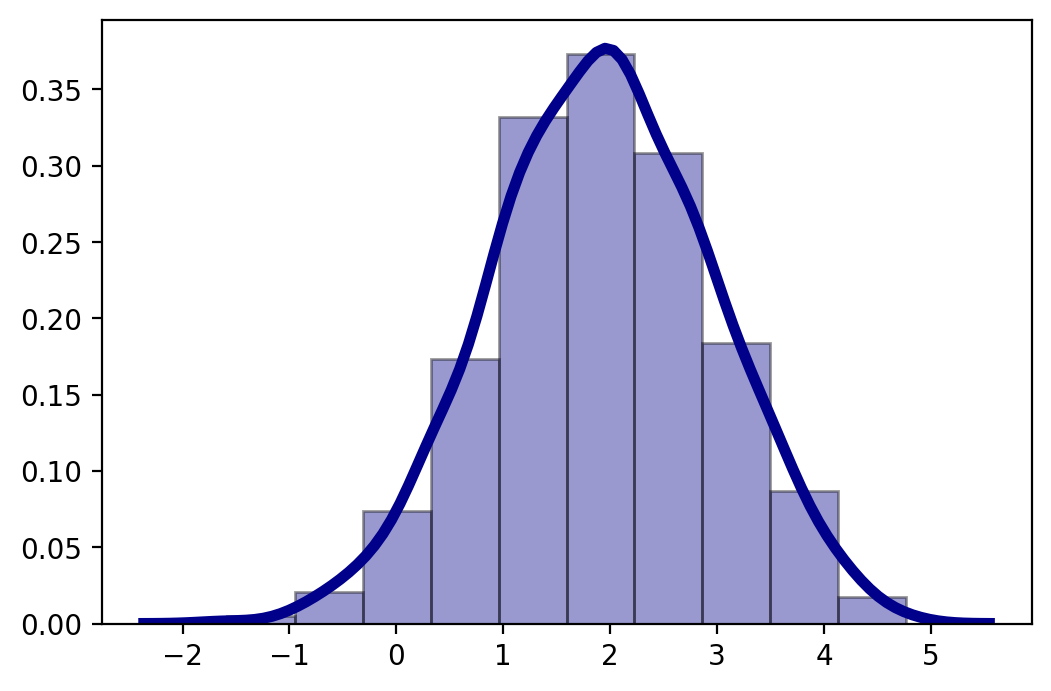

In [189]:
data = {
    "mu": [2.0, 8],
    "sigma": [[1,.3], [.3, 2]]
}

muli_normal_model, multi_normal_fit = fit_model(model_path='stan_model/normal.stan',
                         data = data,
                         i = 1000,
                         seed=1052020,
                         warmup = 0, 
                         chains=1)

muli_normal_params = multi_normal_fit.extract()

sns.distplot(muli_normal_params['result'].T[0].flatten(),
             hist=True,
             kde=True,
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [190]:
to_df = np.array([muli_normal_params['result'].T[0].flatten(),
                 muli_normal_params['result'].T[1].flatten()]).T

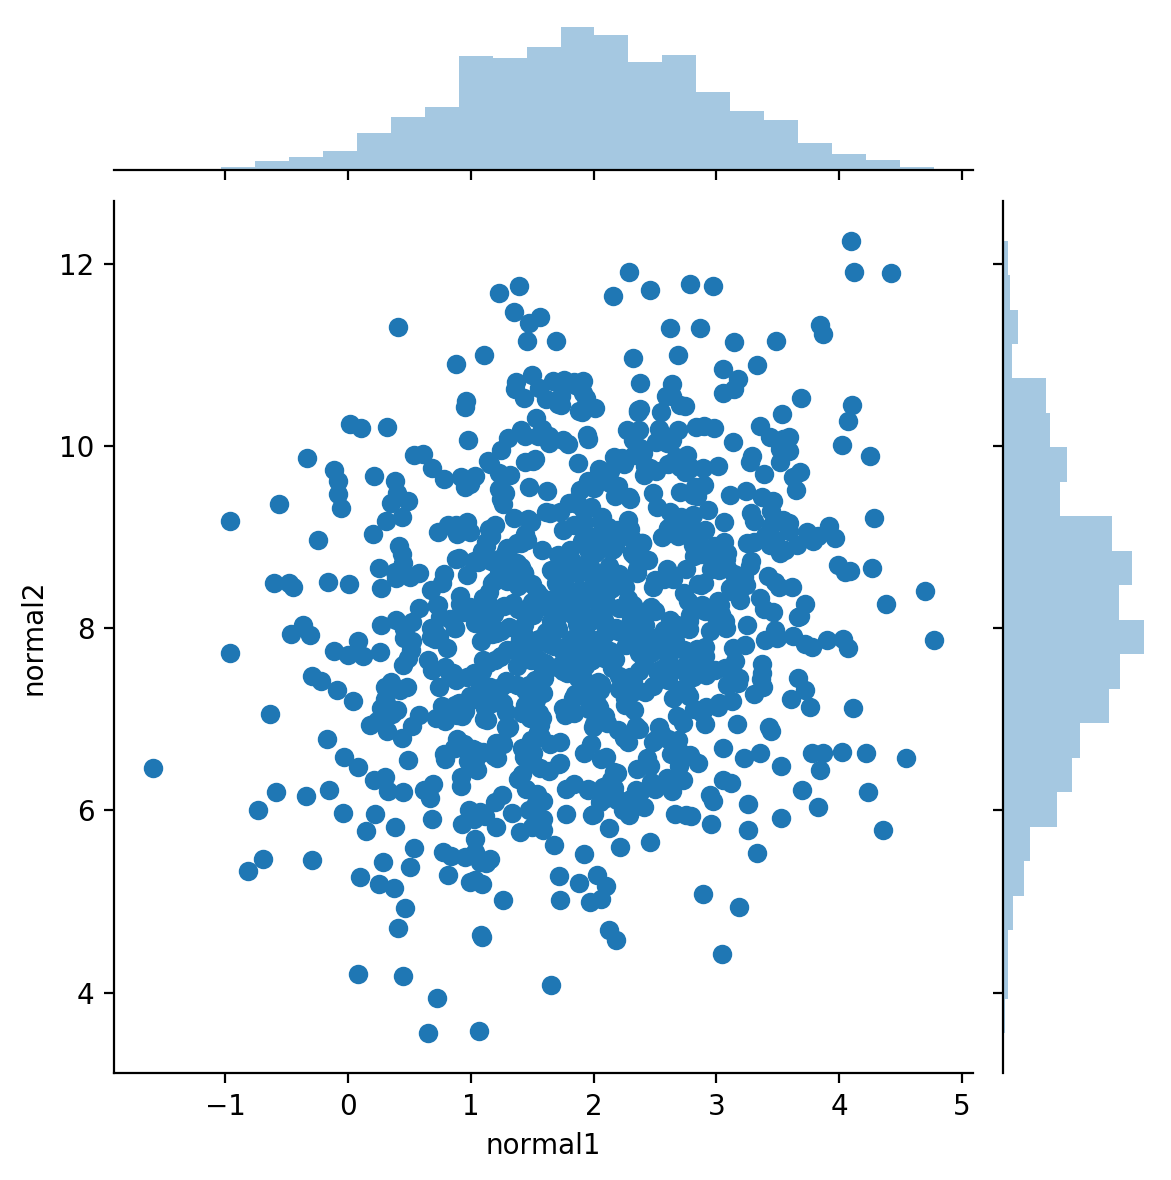

In [192]:
df = pd.DataFrame(to_df, columns=["normal1", "normal2"])
sns.jointplot(x="normal1", y="normal2", data=df);

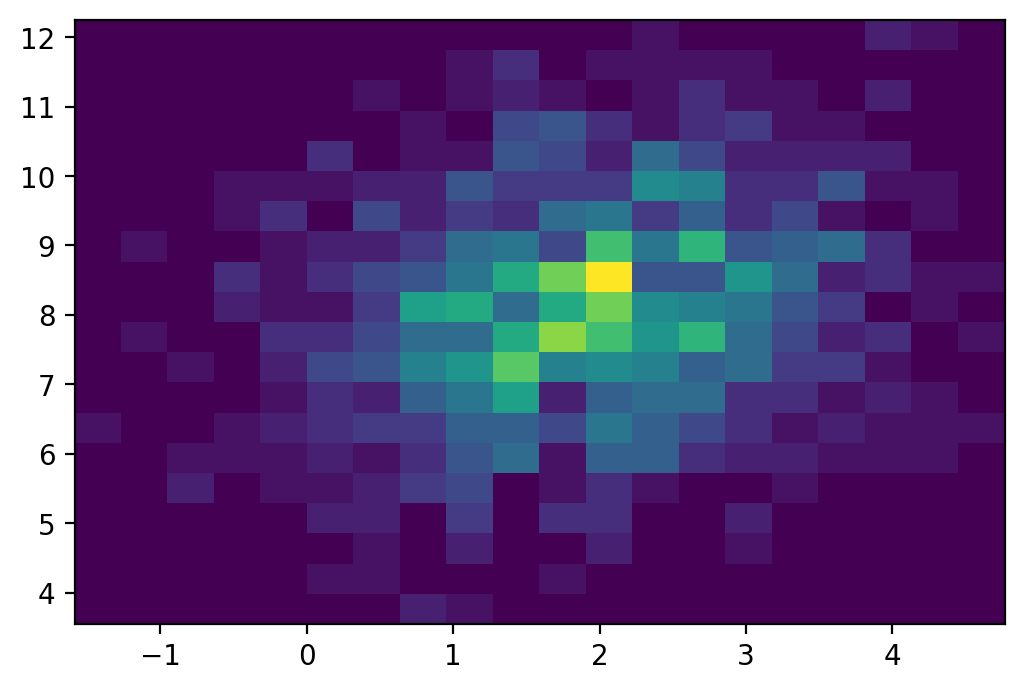

In [196]:
_ = plt.hist2d(muli_normal_params['result'].T[0].flatten(),
           muli_normal_params['result'].T[1].flatten(),
           bins=20, density=True)

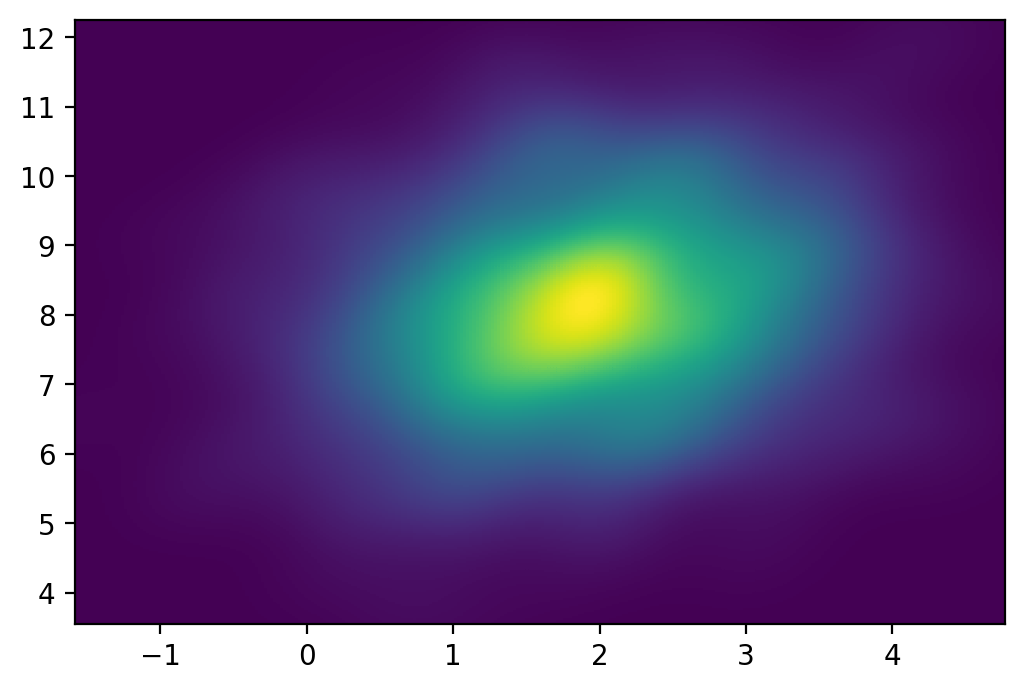

In [197]:
x= np.array(muli_normal_params['result'].T[0].flatten())
y = np.array(muli_normal_params['result'].T[1].flatten())

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()

